<a href="https://colab.research.google.com/github/FajarKKP/Coding/blob/Projects/Simple_DNN_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1/np.exp(3 * season_time))  

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time+phase)% period) / period
  return amplitude+seasonal_pattern(season_time) 
 
def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.rand(len(time))* noise_level 

time = np.arange(4*365+1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 20
slope = 0.09
noise_level = 5  

In [3]:
#Make the series
series = baseline + trend(time,slope) + seasonality(time, period=365, amplitude=amplitude)
#Update it wtih noise
series += noise(time, noise_level, seed=42)

split_time =1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size= 1000

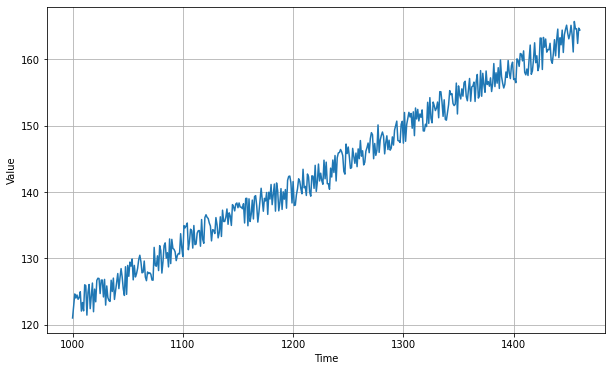

In [4]:
# the plot
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)

In [5]:
#make the windows dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
# Make model
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape=[window_size], activation = tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100,verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


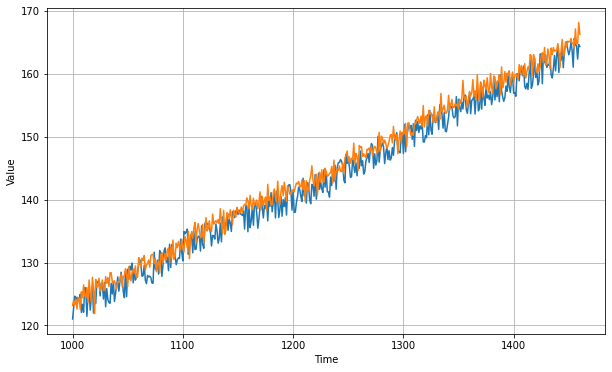

In [7]:
#make the forecast
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
# let's check the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.8323895

In [9]:
# let's try a different model
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape=[window_size], activation = tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 *10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


(1e-08, 0.001, 0.0, 300.0)

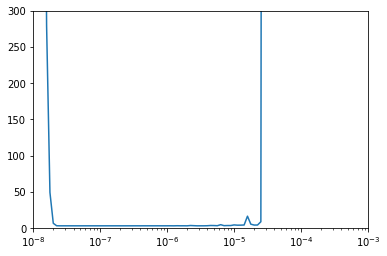

In [10]:
lrs =  1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [14]:
#let's try another one
window_size =  30
dataset = windowed_dataset(x_train, windowed_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape=[window_size], activation = tf.nn.relu),
                                    tf.keras.layers.Dense(10, activation = tf.nn.relu),
                                    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


[3.1735165119171143, 2.8709444999694824, 3.2853200435638428, 3.220639944076538, 3.563344955444336, 2.9482154846191406, 3.1941349506378174, 3.0016562938690186, 3.508911609649658, 3.0944628715515137, 4.539371490478516, 4.084259986877441, 3.16123628616333, 3.0086069107055664, 2.9842541217803955, 3.0689103603363037, 2.9177002906799316, 3.207047462463379, 2.7489821910858154, 3.740717649459839, 5.384145259857178, 3.68900728225708, 4.210803985595703, 3.209190607070923, 3.385000228881836, 2.8779687881469727, 3.2474942207336426, 3.5350406169891357, 3.1778483390808105, 4.125199317932129, 3.0793397426605225, 2.966655731201172, 3.918205738067627, 2.9451920986175537, 2.987253427505493, 2.8791351318359375, 2.9104013442993164, 2.8969764709472656, 3.5046443939208984, 3.3069727420806885, 3.632636547088623, 2.905057668685913, 4.2900238037109375, 5.783333778381348, 3.287647247314453, 3.2026875019073486, 3.4137938022613525, 3.451673984527588, 3.2099037170410156, 3.099970817565918, 2.8217334747314453, 2.97

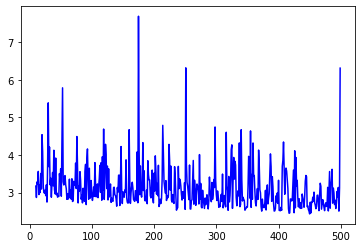

In [16]:
#The first Ten
loss = history.history["loss"]
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, "b", label="Training Loss")
plt.show()

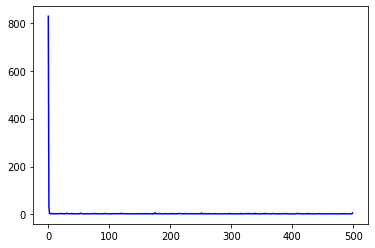

In [17]:
# plot all
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, "b", label="Training Loss")
plt.show()

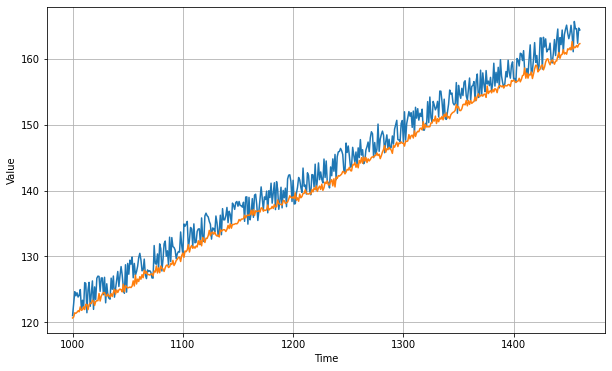

In [19]:
#forecast the final 
forecast = []
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0] 

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [20]:
# Check the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.9770335